# Introduction
* This notebook presents the workflow of the project for the course Text-Mining
* Project is about sentiment analysis of reviews of seven different apps

# Investigation of data

In [1]:
pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.2 MB/s eta 0:00:00


In [2]:
pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import random

from datasets import Dataset
from random import sample
random.seed(13)

# Multinomial Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay

# Distilled BERT
# https://huggingface.co/blog/sentiment-analysis-python
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DistilBertConfig, DistilBertModel, TrainingArguments, Trainer, TextClassificationPipeline
# tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")



In [4]:
df = pd.read_json("hf://datasets/Gopalatius/google-play-review/google_play_dataset.json", lines=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
# Available columns and values
print(df.columns)
df.head(1)


Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'appVersion', 'packageName', 'appName'],
      dtype='object')


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,packageName,appName
0,00938cb6-5ae6-4ac5-aeb0-9c7f8d57ca9e,Janel Reliford,https://play-lh.googleusercontent.com/a-/ALV-U...,"I love Reddit it's a great resource, Community...",5,6,2024.12.0,1710976714000,None,NaN,2024.12.0,com.reddit.frontpage,Reddit


In [6]:
# Number of reviews for the different apps
print(df.groupby(["appName"]).size())
print("\nTotal number of observations: ", sum(df.groupby(["appName"]).size()))

appName
Facebook              11940
Facebook Messenger    14726
Google Maps           12935
Instagram             13930
Reddit                13134
TikTok                13532
Twitter               13532
WhatsApp              12736
dtype: int64

Total number of observations:  106465


In [7]:
# Number of reviews per score
df.groupby(["score"]).size()

,0
score,
1,20895
2,19502
3,18706
4,25074
5,22288


In [8]:
# Number of scores per app
df.groupby(["appName", "score"]).size()

appName             score
Facebook            1        2587
                    2        2985
                    3        2189
                    4        2388
                    5        1791
Facebook Messenger  1        3980
                    2        1393
                    3        3781
                    4        3383
                    5        2189
Google Maps         1        2985
                    2        2786
                    3        2189
                    4        2388
                    5        2587
Instagram           1        2587
                    2        2587
                    3        1791
                    4        2985
                    5        3980
Reddit              1        1990
                    2        1990
                    3        1990
                    4        3383
                    5        3781
TikTok              1        2587
                    2        2587
                    3        2786
                    4        3184
                    5        2388
Twitter             1        2587
                    2        2388
                    3        1990
                    4        4577
                    5        1990
WhatsApp            1        1592
                    2        2786
                    3        1990
                    4        2786
                    5        3582
dtype: int64

### Conclusion after investigation

* Smallest group of reviews is for Facebook Messenger with score 2 (1393).
* Undersampling will be based on this:
    * 1000 observations will be for training
    * 200 for validation
    * rest is for test data

The same number (1000/200/rest) is used for all apps. This will give a balanced training data set, balanced validation training set but an imbalanced test set.  
Since the goal is to generalize the test set does not need to be balanced.

In [9]:
app_name = df["appName"].unique()
scores = range(1, 6)
train_ind = list()
valid_ind = list()
test_ind  = list()
n_train = 1000
n_valid = 200

for app in app_name:
    temp_df = df.loc[df["appName"] == app]

    for score in scores:
        # Grouped by app & score
        ind = temp_df["score"] == score
        # Get index-numbers in original df
        ind = ind[ind].index.to_list()

        # Training samples
        tr_ind = sample(ind, n_train)
        train_ind += tr_ind

        # Validation samples
        # Remaining indices after train indices
        temp_ind = list(set(ind)-set(tr_ind))
        val_ind = sample(temp_ind, n_valid)
        valid_ind += val_ind

        # Test samples
        # Remaining indices
        te_ind = list(set(temp_ind) - set(val_ind))
        test_ind += te_ind


In [10]:
training_data = df.loc[train_ind]
validation_data = df.loc[valid_ind]
test_data = df.loc[test_ind]

# Multinomial Naive Bayes

In [11]:
clf = make_pipeline(
    CountVectorizer(),
    MultinomialNB()
)
clf.fit(training_data["content"],training_data["score"])

pred_nb = clf.predict(test_data["content"])

print(classification_report(test_data["score"], pred_nb))

              precision    recall  f1-score   support

           1       0.60      0.68      0.64     11295
           2       0.46      0.52      0.49      9902
           3       0.43      0.47      0.45      9106
           4       0.62      0.49      0.55     15474
           5       0.70      0.68      0.69     12688

    accuracy                           0.57     58465
   macro avg       0.56      0.57      0.56     58465
weighted avg       0.58      0.57      0.57     58465



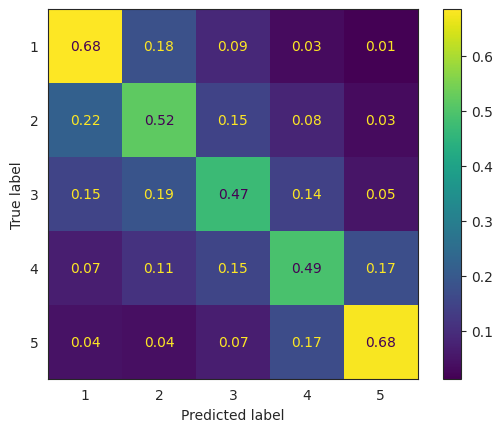

In [12]:
with sns.axes_style("white"):  # Seaborn’s default style doesn’t play well with ConfusionMatrixDisplay, so we change it temporarily
  ConfusionMatrixDisplay.from_estimator(
      clf,             # The model that you want to plot the confusion matrix for
      test_data['content'],    # The input data for the model
      test_data['score'],    # The correct (gold-standard) labels for the input data
      normalize='true',
      values_format='.2f'
   )

In [15]:
pred_nb = clf.predict(test_data.loc[test_data["appName"] == "Facebook"]["content"])
print(classification_report(test_data.loc[test_data["appName"] == "Facebook"]["score"], pred_nb))

              precision    recall  f1-score   support

           1       0.53      0.81      0.64      1387
           2       0.63      0.43      0.51      1785
           3       0.50      0.47      0.48       989
           4       0.78      0.43      0.55      1188
           5       0.50      0.88      0.64       591

    accuracy                           0.57      5940
   macro avg       0.59      0.60      0.57      5940
weighted avg       0.60      0.57      0.56      5940



In [17]:
pred_nb = clf.predict(test_data.loc[test_data["appName"] == "Facebook Messenger"]["content"])
print(classification_report(test_data.loc[test_data["appName"] == "Facebook Messenger"]["score"], pred_nb))

              precision    recall  f1-score   support

           1       0.70      0.59      0.64      2780
           2       0.07      0.78      0.13       193
           3       0.58      0.35      0.43      2581
           4       0.59      0.51      0.55      2183
           5       0.65      0.60      0.62       989

    accuracy                           0.50      8726
   macro avg       0.52      0.56      0.47      8726
weighted avg       0.62      0.50      0.54      8726



In [18]:
pred_nb = clf.predict(test_data.loc[test_data["appName"] == "Google Maps"]["content"])
print(classification_report(test_data.loc[test_data["appName"] == "Google Maps"]["score"], pred_nb))

              precision    recall  f1-score   support

           1       0.70      0.63      0.66      1785
           2       0.60      0.66      0.63      1586
           3       0.50      0.59      0.54       989
           4       0.60      0.60      0.60      1188
           5       0.86      0.75      0.80      1387

    accuracy                           0.65      6935
   macro avg       0.65      0.65      0.65      6935
weighted avg       0.66      0.65      0.65      6935



In [19]:
pred_nb = clf.predict(test_data.loc[test_data["appName"] == "Instagram"]["content"])
print(classification_report(test_data.loc[test_data["appName"] == "Instagram"]["score"], pred_nb))

              precision    recall  f1-score   support

           1       0.60      0.63      0.61      1387
           2       0.50      0.56      0.53      1387
           3       0.26      0.59      0.36       591
           4       0.55      0.46      0.50      1785
           5       0.84      0.63      0.72      2780

    accuracy                           0.58      7930
   macro avg       0.55      0.57      0.54      7930
weighted avg       0.63      0.58      0.59      7930



In [20]:
pred_nb = clf.predict(test_data.loc[test_data["appName"] == "Reddit"]["content"])
print(classification_report(test_data.loc[test_data["appName"] == "Reddit"]["score"], pred_nb))

              precision    recall  f1-score   support

           1       0.57      0.91      0.70       790
           2       0.50      0.67      0.57       790
           3       0.51      0.50      0.50       790
           4       0.71      0.47      0.57      2183
           5       0.79      0.79      0.79      2581

    accuracy                           0.66      7134
   macro avg       0.62      0.67      0.63      7134
weighted avg       0.68      0.66      0.66      7134



In [21]:
pred_nb = clf.predict(test_data.loc[test_data["appName"] == "TikTok"]["content"])
print(classification_report(test_data.loc[test_data["appName"] == "TikTok"]["score"], pred_nb))

              precision    recall  f1-score   support

           1       0.58      0.65      0.62      1387
           2       0.48      0.45      0.47      1387
           3       0.47      0.47      0.47      1586
           4       0.60      0.52      0.56      1984
           5       0.62      0.71      0.66      1188

    accuracy                           0.55      7532
   macro avg       0.55      0.56      0.56      7532
weighted avg       0.55      0.55      0.55      7532



In [22]:
pred_nb = clf.predict(test_data.loc[test_data["appName"] == "Twitter"]["content"])
print(classification_report(test_data.loc[test_data["appName"] == "Twitter"]["score"], pred_nb))

              precision    recall  f1-score   support

           1       0.59      0.79      0.68      1387
           2       0.52      0.54      0.53      1188
           3       0.30      0.43      0.35       790
           4       0.87      0.42      0.56      3377
           5       0.42      0.88      0.57       790

    accuracy                           0.56      7532
   macro avg       0.54      0.61      0.54      7532
weighted avg       0.66      0.56      0.56      7532



In [23]:
pred_nb = clf.predict(test_data.loc[test_data["appName"] == "WhatsApp"]["content"])
print(classification_report(test_data.loc[test_data["appName"] == "WhatsApp"]["score"], pred_nb))

              precision    recall  f1-score   support

           1       0.34      0.65      0.44       392
           2       0.65      0.37      0.47      1586
           3       0.33      0.64      0.44       790
           4       0.43      0.60      0.50      1586
           5       0.82      0.47      0.60      2382

    accuracy                           0.51      6736
   macro avg       0.51      0.55      0.49      6736
weighted avg       0.60      0.51      0.52      6736



# Training BERT-model

In [ ]:
# Transforming data to type "datasets.arrow_dataset.Dataset"

training_data = df.loc[train_ind]
validation_data = df.loc[valid_ind]
test_data = df.loc[test_ind]

# Bert models wants labels from 0 to 4 instead of 1 to 5
training_data["score"] += -1
validation_data["score"] += -1
test_data["score"] += -1


training_data = dict({"text" : training_data["content"],
                     "label" : training_data["score"]
})

validation_data = dict({"text" : validation_data["content"],
                        "label" : validation_data["score"]
})
test_data = dict({"text" : test_data["content"],
                  "label" : test_data["score"]
})


training_data = Dataset.from_dict(training_data)
validation_data = Dataset.from_dict(validation_data)
test_data = Dataset.from_dict(test_data)

In [ ]:
# Do not delete
# Wand
# f2bca7abf33eb282605b44f81908a815b2ecda8e

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)

tokenized_train = training_data.map(preprocess_function)
tokenized_valid = validation_data.map(preprocess_function)
tokenized_test = test_data.map(preprocess_function)




tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/58465 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer
import evaluate

# After training the model for 15 epochs and saving it, it would not work the day after with the following error:
# "safetensorerror: error while deserializing header: metadataincompletebuffer"
# For 7 epochs it was 0.825857
# For 8 epochs it was 0.831637
# For 15 epochs the F1-score was 0.850791.

# I had to retrain the model and with limited GPU time I set on 5 epochs (score was 0.795528)


def compute_metrics(eval_pred):
   load_accuracy = evaluate.load("accuracy")
   load_f1 = evaluate.load("f1")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels, average = "macro")["f1"]
   return {"accuracy": accuracy, "f1": f1}

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=100,
    per_device_eval_batch_size=100,
    num_train_epochs=5,
    weight_decay=0.01,
)


trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_valid,
   tokenizer=tokenizer,
   compute_metrics=compute_metrics,
)
# Wand
# f2bca7abf33eb282605b44f81908a815b2ecda8e

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-ac9d66744f1e>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.036057,0.563625,0.564438
2,1.147500,0.918286,0.635125,0.629189
3,0.904300,0.824088,0.698750,0.696768
4,0.733400,0.775860,0.729250,0.728809
5,0.635000,0.761170,0.743500,0.742904


TrainOutput(global_step=2000, training_loss=0.855047119140625, metrics={'train_runtime': 2257.062, 'train_samples_per_second': 88.611, 'train_steps_per_second': 0.886, 'total_flos': 6867456642660000.0, 'train_loss': 0.855047119140625, 'epoch': 5.0})

In [ ]:
trainer.save_model("./trained_model")

In [ ]:
# Save results to zip
!zip -r /content/file.zip /content/trained_model
# Look in files to the left to download manually


  adding: content/trained_model/ (stored 0%)
  adding: content/trained_model/vocab.txt (deflated 53%)
  adding: content/trained_model/special_tokens_map.json (deflated 42%)
  adding: content/trained_model/config.json (deflated 51%)
  adding: content/trained_model/tokenizer_config.json (deflated 76%)
  adding: content/trained_model/tokenizer.json (deflated 71%)
  adding: content/trained_model/model.safetensors (deflated 8%)
  adding: content/trained_model/training_args.bin (deflated 51%)


# Loading pretrained Bert model (not used anymore)

In [ ]:
# Load pretrained model
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline
model2 = AutoModelForSequenceClassification.from_pretrained("./trained_model")
tokenizer = AutoTokenizer.from_pretrained("./trained_model")
pipe = TextClassificationPipeline(model=model2, tokenizer=tokenizer)

# Need to run code that process data + tokenization

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


# Predicting with BERT model on test data

In [ ]:
# Splitting data per app
test_facebook = test_data[test_data["appName"] == "Facebook"]
test_facebook_mess = test_data[test_data["appName"] == "Facebook Messenger"]
test_google = test_data[test_data["appName"] == "Google Maps"]
test_instagram = test_data[test_data["appName"] == "Instagram"]
test_reddit = test_data[test_data["appName"] == "Reddit"]
test_tiktok = test_data[test_data["appName"] == "TikTok"]
test_twitter = test_data[test_data["appName"] == "Twitter"]
test_whatsapp = test_data[test_data["appName"] == "WhatsApp"]

In [ ]:
# Predict result to original labels
dict_val = {
    "LABEL_0" : 1,
    "LABEL_1" : 2,
    "LABEL_2" : 3,
    "LABEL_3" : 4,
    "LABEL_4" : 5
}
from tqdm import tqdm

def pred(data):
  res = list()
  for row in tqdm(data):
    pred_val = pipe(row)
    res.append(dict_val[pred_val[0]["label"]])
  return res




In [ ]:
pred_facebook = pred(list(test_facebook["content"]))

100%|██████████| 5940/5940 [14:31<00:00,  6.82it/s]


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
confusion_matrix(test_facebook["score"], pred_facebook)

array([[1219,  123,   29,    4,   12],
       [ 244, 1212,  263,   50,   16],
       [  34,  123,  752,   57,   23],
       [  12,   47,  119,  833,  177],
       [   2,    7,    1,   12,  569]])

In [ ]:
print(confusion_matrix(test_facebook["score"], pred_facebook, normalize="true"))
print("F1-score per class:", f1_score(test_facebook["score"], pred_facebook, average=None))
print("Facebook Macro F1-score:", f1_score(test_facebook["score"], pred_facebook, average="macro"))

[[0.87887527 0.08868061 0.02090844 0.00288392 0.00865177]
 [0.13669468 0.6789916  0.14733894 0.0280112  0.00896359]
 [0.03437816 0.12436805 0.760364   0.05763397 0.02325581]
 [0.01010101 0.03956229 0.10016835 0.70117845 0.1489899 ]
 [0.00338409 0.01184433 0.00169205 0.02030457 0.96277496]]
F1-score per class: [0.84126984 0.73521383 0.69856015 0.77705224 0.81988473]
Facebook Macro F1-score: 0.7743961571371293


In [ ]:
pred_facebook_mess = pred(list(test_facebook_mess["content"]))
confusion_matrix(test_facebook_mess["score"], pred_facebook_mess)

100%|██████████| 8726/8726 [20:15<00:00,  7.18it/s]


array([[2182,  460,  110,   19,    9],
       [   8,  179,    5,    1,    0],
       [ 109,  375, 1592,  424,   81],
       [  57,   84,  334, 1467,  241],
       [   8,    8,   32,  110,  831]])

In [ ]:
print(confusion_matrix(test_facebook_mess["score"], pred_facebook_mess, normalize="true"))
print("F1-score per class:", f1_score(test_facebook_mess["score"], pred_facebook_mess, average=None))
print("Facebook messenger Macro F1-score:", f1_score(test_facebook_mess["score"], pred_facebook_mess, average="macro"))

[[0.78489209 0.16546763 0.03956835 0.00683453 0.00323741]
 [0.04145078 0.92746114 0.02590674 0.00518135 0.        ]
 [0.04223169 0.14529252 0.61681519 0.16427741 0.03138318]
 [0.02611086 0.03847916 0.15300046 0.67201099 0.11039853]
 [0.00808898 0.00808898 0.03235592 0.11122346 0.84024267]]
F1-score per class: [0.84836703 0.27559661 0.68414267 0.69790676 0.77266388]
Facebook messenger Macro F1-score: 0.6557353896069812


In [ ]:
pred_google = pred(list(test_google["content"]))
confusion_matrix(test_google["score"], pred_google)

100%|██████████| 6935/6935 [16:17<00:00,  7.10it/s]


array([[1411,  279,   78,   13,    4],
       [ 232, 1166,  152,   27,    9],
       [  34,  114,  778,   57,    6],
       [  13,   35,  118,  915,  107],
       [  11,   16,   18,  112, 1230]])

In [ ]:
print(confusion_matrix(test_google["score"], pred_google, normalize="true"))
print("F1-score per class:", f1_score(test_google["score"], pred_google, average=None))
print("Google Macro F1-score:", f1_score(test_google["score"], pred_google, average="macro"))

[[0.79047619 0.15630252 0.04369748 0.00728291 0.0022409 ]
 [0.14627995 0.73518285 0.09583859 0.01702396 0.00567465]
 [0.03437816 0.11526795 0.78665319 0.05763397 0.00606673]
 [0.01094276 0.02946128 0.0993266  0.77020202 0.09006734]
 [0.00793079 0.01153569 0.01297765 0.08074982 0.88680606]]
F1-score per class: [0.80952381 0.72966208 0.72948898 0.79152249 0.89682829]
Google Macro F1-score: 0.7914051302634091


In [ ]:
pred_instagram = pred(list(test_instagram["content"]))
confusion_matrix(test_instagram["score"], pred_instagram)

100%|██████████| 7930/7930 [16:50<00:00,  7.85it/s]


array([[1123,  194,   59,    8,    3],
       [ 168, 1038,  145,   28,    8],
       [  16,   51,  490,   30,    4],
       [  37,   82,  244, 1190,  232],
       [  49,   69,  113,  423, 2126]])

In [ ]:
print(confusion_matrix(test_instagram["score"], pred_instagram, normalize="true"))
print("F1-score per class:", f1_score(test_instagram["score"], pred_instagram, average=None))
print("Instagram Macro F1-score:", f1_score(test_instagram["score"], pred_instagram, average="macro"))

[[0.80966114 0.13987022 0.04253785 0.00576784 0.00216294]
 [0.12112473 0.74837779 0.10454218 0.02018745 0.00576784]
 [0.02707276 0.08629442 0.82910321 0.05076142 0.00676819]
 [0.02072829 0.04593838 0.13669468 0.66666667 0.12997199]
 [0.0176259  0.02482014 0.04064748 0.15215827 0.7647482 ]]
F1-score per class: [0.80791367 0.73590925 0.59683313 0.68706697 0.8251504 ]
Instagram Macro F1-score: 0.7305746847708503


In [ ]:
pred_reddit = pred(list(test_reddit["content"]))
confusion_matrix(test_reddit["score"], pred_reddit)

100%|██████████| 7134/7134 [12:03<00:00,  9.86it/s]


array([[ 750,   34,    5,    1,    0],
       [  81,  641,   52,   12,    4],
       [  10,   51,  660,   60,    9],
       [  17,   56,  179, 1644,  287],
       [   0,   13,   38,  367, 2163]])

In [ ]:
print(confusion_matrix(test_reddit["score"], pred_reddit, normalize="true"))
print("F1-score per class:", f1_score(test_reddit["score"], pred_reddit, average=None))
print("Reddit Macro F1-score:", f1_score(test_reddit["score"], pred_reddit, average="macro"))

[[0.94936709 0.04303797 0.00632911 0.00126582 0.        ]
 [0.10253165 0.81139241 0.06582278 0.01518987 0.00506329]
 [0.01265823 0.06455696 0.83544304 0.07594937 0.01139241]
 [0.00778745 0.02565277 0.08199725 0.75309208 0.13147045]
 [0.         0.00503681 0.01472298 0.14219295 0.83804727]]
F1-score per class: [0.91019417 0.80883281 0.76566125 0.7705648  0.85765266]
Reddit Macro F1-score: 0.8225811382950499


In [ ]:
pred_tiktok = pred(list(test_tiktok["content"]))
confusion_matrix(test_tiktok["score"], pred_tiktok)

100%|██████████| 7532/7532 [14:42<00:00,  8.53it/s]


array([[1128,  167,   64,   12,   16],
       [ 182,  936,  198,   44,   27],
       [  46,  173, 1165,  171,   31],
       [  29,   67,  268, 1400,  220],
       [   6,    6,   32,  120, 1024]])

In [ ]:
print(confusion_matrix(test_tiktok["score"], pred_tiktok, normalize="true"))
print("F1-score per class:", f1_score(test_tiktok["score"], pred_tiktok, average=None))
print("TikTok Macro F1-score:", f1_score(test_tiktok["score"], pred_tiktok, average="macro"))

[[0.81326604 0.12040375 0.04614275 0.00865177 0.01153569]
 [0.13121846 0.67483778 0.14275415 0.03172314 0.01946647]
 [0.02900378 0.10907945 0.73455233 0.10781841 0.01954603]
 [0.01461694 0.03377016 0.13508065 0.70564516 0.1108871 ]
 [0.00505051 0.00505051 0.02693603 0.1010101  0.86195286]]
F1-score per class: [0.81209503 0.68421053 0.70329007 0.75046904 0.81723863]
TikTok Macro F1-score: 0.7534606597166288


In [ ]:
pred_twitter = pred(list(test_twitter["content"]))
confusion_matrix(test_twitter["score"], pred_twitter)

100%|██████████| 7532/7532 [14:32<00:00,  8.63it/s]


array([[1168,  150,   57,    8,    4],
       [ 145,  855,  143,   39,    6],
       [  21,   99,  601,   64,    5],
       [  66,  133,  512, 2126,  540],
       [   1,    3,    3,   33,  750]])

In [ ]:
print(confusion_matrix(test_twitter["score"], pred_twitter, normalize="true"))
print("F1-score per class:", f1_score(test_twitter["score"], pred_twitter, average=None))
print("Twitter Macro F1-score:", f1_score(test_twitter["score"], pred_twitter, average="macro"))

[[0.84210526 0.10814708 0.04109589 0.00576784 0.00288392]
 [0.12205387 0.71969697 0.12037037 0.03282828 0.00505051]
 [0.02658228 0.12531646 0.76075949 0.08101266 0.00632911]
 [0.01954397 0.03938407 0.15161386 0.62955286 0.15990524]
 [0.00126582 0.00379747 0.00379747 0.04177215 0.94936709]]
F1-score per class: [0.83787661 0.70428336 0.57075024 0.75296618 0.71599045]
Twitter Macro F1-score: 0.716373368491913


In [ ]:
pred_whatsapp = pred(test_whatsapp["content"])
confusion_matrix(test_whatsapp["score"], pred_whatsapp)

100%|██████████| 6736/6736 [15:32<00:00,  7.22it/s]


array([[ 358,   15,   14,    5,    0],
       [ 189,  979,  289,   95,   34],
       [  20,   41,  661,   60,    8],
       [  29,   48,  222, 1115,  172],
       [  46,   47,  153,  527, 1609]])

In [ ]:
print(confusion_matrix(test_whatsapp["score"], pred_whatsapp, normalize="true"))
print("F1-score per class:", f1_score(test_whatsapp["score"], pred_whatsapp, average=None))
print("Whatsapp Macro F1-score:", f1_score(test_whatsapp["score"], pred_whatsapp, average="macro"))

[[0.91326531 0.03826531 0.03571429 0.0127551  0.        ]
 [0.11916772 0.61727617 0.18221942 0.05989912 0.02143758]
 [0.02531646 0.05189873 0.83670886 0.07594937 0.01012658]
 [0.01828499 0.03026482 0.13997478 0.70302648 0.10844893]
 [0.0193115  0.01973132 0.06423174 0.22124265 0.67548279]]
F1-score per class: [0.69245648 0.72091311 0.6209488  0.65820543 0.76527943]
Whatsapp Macro F1-score: 0.6915606499279486


In [ ]:
# All together
pred_labels = pred_facebook + pred_facebook_mess + \
               pred_google + pred_instagram + \
               pred_reddit + pred_tiktok + \
               pred_twitter + pred_whatsapp

true_labels = list(test_facebook["score"]) + list(test_facebook_mess["score"]) + \
              list(test_google["score"]) + list(test_instagram["score"]) + \
              list(test_reddit["score"]) + list(test_tiktok["score"]) + \
              list(test_twitter["score"]) + list(test_whatsapp["score"])

print(confusion_matrix(true_labels, pred_labels, normalize="true"))
print("F1-score per class:", f1_score(true_labels, pred_labels, average=None))
print("Macro F1-score:", f1_score(true_labels, pred_labels, average="macro"))


[[0.82682603 0.12589641 0.03683046 0.00619743 0.00424967]
 [0.12613613 0.70753383 0.12593415 0.02989295 0.01050293]
 [0.03184713 0.11278278 0.73566879 0.10136174 0.01833956]
 [0.01680238 0.03567274 0.12899056 0.69083624 0.12769807]
 [0.0096942  0.01331967 0.0307377  0.13430013 0.8119483 ]]
F1-score per class: [0.82807235 0.69787827 0.67482623 0.7332716  0.81487048]
Macro F1-score: 0.7497837869253305


# Post processing

In [ ]:
# Data labeled as 5 in test data
sub_data_5 = test_data[test_data["score"] == 5]
pred = clf.predict(sub_data_5["content"])

# Data labeled as 5 but predicted as 1 for MNB
sub_data_5_1 = sub_data_5[pred == 1]

# Example
print("Predicted as 1 (MNB):\n", sub_data_5_1["content"].iloc[2])

# Save to see if BERT model can label this better.
pred_obs_bert = sub_data_5_1["content"].iloc[2]
pred_val = pipe(pred_obs_bert)
print("BERT model predicts on the same text as:", dict_val[pred_val[0]["label"]], "\n\n")


# Example
print("Predicted as 1 (MNB):\n", sub_data_5_1["content"].iloc[3])

# Save to see if BERT model can label this better.
pred_obs_bert = sub_data_5_1["content"].iloc[3]
pred_val = pipe(pred_obs_bert)
print("BERT model predicts on the same text as:", dict_val[pred_val[0]["label"]], "\n\n")


# Example
print("Predicted as 1 (MNB):\n", sub_data_5_1["content"].iloc[4])

# Save to see if BERT model can label this better.
pred_obs_bert = sub_data_5_1["content"].iloc[4]
pred_val = pipe(pred_obs_bert)
print("BERT model predicts on the same text as:", dict_val[pred_val[0]["label"]], "\n\n")

# Example
print("Predicted as 1 (MNB):\n", sub_data_5_1["content"].iloc[5])

# Save to see if BERT model can label this better.
pred_obs_bert = sub_data_5_1["content"].iloc[5]
pred_val = pipe(pred_obs_bert)
print("BERT model predicts on the same text as:", dict_val[pred_val[0]["label"]])

Predicted as 1 (MNB):
 Keep getting lost on it, open up something and the next thing I know it's a hour later, brilliant..
BERT model predicts on the same text as: 5 


Predicted as 1 (MNB):
 To be absolutely honest they haven't gone soft you can watch all kinds of videos other platforms wouldn't because they are lame 🤷
BERT model predicts on the same text as: 5 


Predicted as 1 (MNB):
 Support has zero reading comprehension and doesn't keep their word other than that great
BERT model predicts on the same text as: 5 


Predicted as 1 (MNB):
 This is such a refreshing change from Facebook and even Tumblr that those apps aren't even used on my phone anymore.
BERT model predicts on the same text as: 5
